#  Homework 5 - Berkeley STAT 157

**Your name: Zhiming, SID 3034485754** (Please add your name, and SID to ease Ryan and Rachel to grade.)

**Please submit your homework through [gradescope](http://gradescope.com/) instead of Github, so you will get the score distribution for each question. Please enroll in the [class](https://www.gradescope.com/courses/42432) by the Entry code: MXG5G5** 

Handout 2/19/2019, due 2/26/2019 by 4pm in Git by committing to your repository.

In this homework, we will model covariate shift and attempt to fix it using logistic regression. This is a fairly realistic scenario for data scientists. To keep things well under control and understandable we will use [Fashion-MNIST](http://d2l.ai/chapter_linear-networks/fashion-mnist.html) as the data to experiment on. 

Follow the instructions from the Fashion MNIST notebook to get the data.

In [112]:
%matplotlib inline
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import d2l
import numpy as np
import matplotlib.pyplot as plt
import mxnet as mx
import time

## 1. Logistic Regression

1. Implement the logistic loss function $l(y,f) = -\log(1 + \exp(-y f))$ in Gluon.
2. Plot its values and its derivative for $y = 1$ and $f \in [-5, 5]$, using automatic differentiation in Gluon.
3. Generate training and test datasets for a binary classification problem using Fashion-MNIST with class $1$ being a combination of `shirt` and `sweater` and class $-1$ being the combination of `sandal` and `sneaker` categories. 
4. Train a binary classifier of your choice (it can be linear or a simple MLP such as from a previous lecture) using half the data (i.e. $12,000$ observations mixed as abvove) and one using the full dataset (i.e. $24,000$ observations as arising from the 4 categories) and report its accuracy. 

Hint - you should encapsulate the training and reporting code in a callable function since you'll need it quite a bit in the following. 

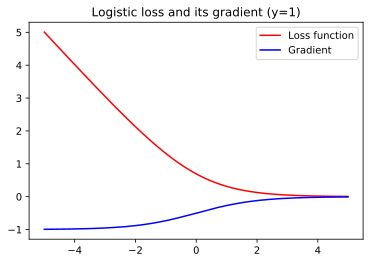

In [150]:
# for question 1 & 2
def logistic_loss(y, f):
    l = nd.log(1+nd.exp(-y*f))
    return l
f = nd.arange(-5, 5, 0.01)
f.attach_grad()
# for y = 1
y = nd.ones(shape = f.shape)
with autograd.record():
    l = logistic_loss(y, f)
l.backward()
# for loss function
plt.figure()
plt.title('Logistic loss and its gradient (y=1)')
plt.plot(f.asnumpy(), l.asnumpy(), color = 'r',\
         label = 'Loss function')
# for grad
plt.plot(f.asnumpy(), f.grad.asnumpy(), color = 'b',\
        label = 'Gradient')
plt.legend(loc = 'upper right')
plt.show()

In [114]:
# for question 3
def transform(data, label):
    return mx.nd.transpose(data.astype(np.float32), (2,0,1))/255, label.astype(np.float32)
mnist_train = gdata.vision.FashionMNIST(train=True, transform = transform)
mnist_test = gdata.vision.FashionMNIST(train=False, transform = transform)
feature, label = mnist_train[0]
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # Here _ means that we ignore (not use) variables
    _, figs = d2l.plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28, 28)).asnumpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
# pick out pullover/shirt, and sneaker/scandal
def preprocess(mnist_train, mnist_test):
    train_data = []
    for i in range(len(mnist_train)):
        if mnist_train[i][1] == 2 or mnist_train[i][1] == 6:
            tmp, tmp_label = mnist_train[i]
            tmp_label = 1
            train_data.append(tuple((tmp, tmp_label)))
        elif mnist_train[i][1] == 5 or mnist_train[i][1] == 7:
            tmp, tmp_label = mnist_train[i]
            tmp_label = -1
            train_data.append(tuple((tmp, tmp_label)))
    test_data = []
    for i in range(len(mnist_test)):
        if mnist_test[i][1] == 2 or mnist_test[i][1] == 6:
            tmp, tmp_label = mnist_test[i]
            tmp_label = 1
            test_data.append(tuple((tmp, tmp_label)))
        elif mnist_test[i][1] == 5 or mnist_test[i][1] == 7:
            tmp, tmp_label = mnist_test[i]
            tmp_label = -1
            test_data.append(tuple((tmp, tmp_label)))
    return train_data, test_data

In [163]:
def get_net():
    net = gluon.nn.Sequential()
    net.add(nn.Dense(128),
            nn.Dense(2))
    return net

In [159]:
def init_net(net, optimizer='sgd', learning_rate=0.1, weight_decay=1e-6, ctx=mx.cpu()):
    net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
    trainer = gluon.Trainer(net.collect_params(), 
                            optimizer, 
                            {'learning_rate': learning_rate, 'wd': weight_decay})
    return trainer

def accuracy(data_iterator, net,ctx=mx.cpu()):
    acc = mx.metric.Accuracy()
    for (data, label) in data_iterator:
        #data = data.as_in_context(ctx)
        #label = label.as_in_context(ctx)
        output = net(data)
        predictions = mx.nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [117]:
def plot_accuracies(training_accuracies, validation_accuracies):
    epochs = len(training_accuracies)
    plt.clf()
    fig, ax = plt.subplots()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    train_plot, = ax.plot(range(epochs), training_accuracies, label="Training accuracy")
    validation_plot, = ax.plot(range(epochs), validation_accuracies, label="Validation accuracy")
    plt.legend(handles=[train_plot,validation_plot])
    plt.xticks(np.arange(0, epochs, 5))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
    plt.show()

In [156]:
def train(net, trainer, train_data, validation_data, epochs, ctx=mx.cpu()):
    training_accuracies = []
    validation_accuracies = []
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    for e in range(epochs):
        tic = time.time()
        for (data, label) in train_data:
            #data  = data.as_in_context(ctx)
            #label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss = softmax_cross_entropy(output, label)
                loss.backward()
            trainer.step(data.shape[0])
        toc = time.time()
        train_accuracy = accuracy(train_data, net)
        training_accuracies.append(train_accuracy)
        validation_accuracy = accuracy(validation_data, net)
        validation_accuracies.append(validation_accuracy)
        print("Epoch#%d Time=%.2f Training=%.4f Validation=%.4f Diff=%.4f" 
              % (e, toc-tic, train_accuracy, validation_accuracy, train_accuracy-validation_accuracy))
    return training_accuracies, validation_accuracies

In [148]:
epochs = 50
train_data, test_data = preprocess(mnist_train, mnist_test)
train_data = gluon.data.DataLoader(train_data, batch_size=64, shuffle=True)
validation_data = gluon.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [164]:
net = get_net()
print(net)
trainer = init_net(net)
training_accuracies, validation_accuracies = train(net, trainer, train_data, validation_data, epochs)
plot_accuracies(training_accuracies, validation_accuracies)

Sequential(
  (0): Dense(None -> 128, linear)
  (1): Dense(None -> 2, linear)
)
Epoch#0 Time=1.73 Training=0.4994 Validation=0.4995 Diff=-0.0001
Epoch#1 Time=1.43 Training=0.4995 Validation=0.4995 Diff=0.0000
Epoch#2 Time=1.49 Training=0.4997 Validation=0.4995 Diff=0.0002
Epoch#3 Time=1.42 Training=0.4998 Validation=0.4998 Diff=0.0001
Epoch#4 Time=1.39 Training=0.4998 Validation=0.4998 Diff=0.0001
Epoch#5 Time=1.47 Training=0.4997 Validation=0.4995 Diff=0.0002
Epoch#6 Time=1.44 Training=0.4999 Validation=0.4998 Diff=0.0002
Epoch#7 Time=1.72 Training=0.4998 Validation=0.4995 Diff=0.0003
Epoch#8 Time=1.74 Training=0.4999 Validation=0.4998 Diff=0.0002
Epoch#9 Time=1.44 Training=0.4999 Validation=0.4998 Diff=0.0001
Epoch#10 Time=1.48 Training=0.4998 Validation=0.4995 Diff=0.0003
Epoch#11 Time=1.47 Training=0.4999 Validation=0.4998 Diff=0.0001
Epoch#12 Time=1.48 Training=0.4999 Validation=0.4998 Diff=0.0001
Epoch#13 Time=1.53 Training=0.4999 Validation=0.4998 Diff=0.0002
Epoch#14 Time=1.48 

KeyboardInterrupt: 

## 2. Covariate Shift

Your goal is to introduce covariate shit in the data and observe the accuracy. For this, compose a dataset of $12,000$ observations, given by a mixture of `shirt` and `sweater` and of `sandal` and `sneaker` respectively, where you use a fraction $\lambda \in \{0.05, 0.1, 0.2, \ldots 0.8, 0.9, 0.95\}$ of one and a fraction of $1-\lambda$ of  the other datasets respectively. For instance, you might pick for $\lambda = 0.1$ a total of $600$ `shirt` and $5,400$ `sweater` images and likewise $600$ `sandal` and $5,400$ `sneaker` photos, yielding a total of $12,000$ images for training. Note that the test set remains unbiased, composed of $2,000$ photos for the `shirt` + `sweater` category and of the `sandal` + `sneaker` category each.

1. Generate training sets that are appropriately biased. You should have 11 datasets.
2. Train a binary classifier using this and report the test set accuracy on the unbiased test set. 

## 3. Covariate Shift Correction

Having observed that covariate shift can be harmful, let's try fixing it. For this we first need to compute the appropriate propensity scores $\frac{dp(x)}{dq(x)}$. For this purpose pick a biased dataset, let's say with $\lambda = 0.1$ and try to fix the covariate shift.

1. When training a logistic regression binary classifier to fix covariate shift, we assumed so far that both sets are of equal size. Show that re-weighting data in training and test set appropriately can help address the issue when both datasets have different size. What is the weighting?
2. Train a binary classifier (using logistic regression) distinguishing between the biased training set and the unbiased test set. Note - you need to weigh the data. 
3. Use the scores to compute weights on the training set. Do they match the weight arising from the biasing distribution $\lambda$? 
4. Train a binary classifier of the covariate shifted problem using the weights obtained previously and report the accuracy. Note - you will need to modify the training loop slightly such that you can compute the gradient of a weighted sum of losses. 
